# Deadbeat controller for the double integrator

Consider a mass of 1kg moving in one direction on a friction-free horizontal surface. We can apply a force to the mass (input signal $u$), and the mass is also subject to disturbance forces $v$. We are interested in controlling the position $z$ of the mass. In continuous time the dynamics are described by
$$ \ddot{z} = u + v. $$
Introducing the state variables $x_1=z$ and $x_2=\dot{z}$, the system can also be represented on state-space form with state vector $x = \begin{bmatrix} z & \dot{z}\end{bmatrix}^T$ as 
\begin{align}
\dot{x} &= \underbrace{\begin{bmatrix} 0 & 1\\0 & 0\end{bmatrix}}_{A}x + \underbrace{\begin{bmatrix}0\\1\end{bmatrix}}_{B}u + \underbrace{\begin{bmatrix}0\\1\end{bmatrix}}_{B}v\\
y &= \underbrace{\begin{bmatrix}1 & 0 \end{bmatrix}}_C x
\end{align}

## Discrete-time state-space model
The discrete-time state-space model using a sampling period $h$ is
\begin{align}
x(k+1) &= \Phi(h)x(k) + \Gamma(h)u + \Gamma(h)v\\
y(k) &= Cx(k)
\end{align}
where
$$ \Phi(h) = \mathrm{e}^{Ah} = \begin{bmatrix} 1 & h\\0 & 1 \end{bmatrix}$$
and
$$ \Gamma(h) = \int_0^h \mathrm{e}^{As}B ds = \begin{bmatrix} \frac{h^2}{2}\\h \end{bmatrix}.$$
### Verification by symbolic computation

In [1]:
import numpy as np
import sympy as sy
sy.init_printing(use_latex='mathjax', order='lex')

h = sy.symbols('h', real=True, positive=True)
A = sy.Matrix([[0,1], [0,0]])
B = sy.Matrix([[0],[1]])
Phi = sy.simplify(sy.exp(A*h))
Phi

⎡1  h⎤
⎢    ⎥
⎣0  1⎦

In [2]:
s = sy.symbols('s')
Gamma = sy.integrate(sy.exp(A*s)*B, (s, 0, h))
Gamma

⎡ 2⎤
⎢h ⎥
⎢──⎥
⎢2 ⎥
⎢  ⎥
⎣h ⎦

## Reachability 
The controllability matrix for this second order system becomes
$$ W_c = \begin{bmatrix} \Gamma & \Phi\Gamma \end{bmatrix} = \begin{bmatrix} \frac{h^2}{2} & \frac{3h^2}{2}\\h & h\end{bmatrix}, $$
with determinant
$$\det W_c = \frac{h^3}{2}(1 - 3) = -h^3,$$
which is different from zero since $h>0$.
It is hence possible to reach any point in the state-space from any other point in just two steps (two sampling periods).
### Verification by symbolic computation

In [3]:
Wc = sy.BlockMatrix([[Gamma, Phi*Gamma]]).as_explicit()
Wc

⎡ 2     2⎤
⎢h   3⋅h ⎥
⎢──  ────⎥
⎢2    2  ⎥
⎢        ⎥
⎣h    h  ⎦

In [4]:
sy.det(Wc)

  3
-h 

## Designing an input sequence
We now know that the system is reachable. This means that we can take the system from the origin in the state-space (position zero and velocity zero) to any other point in state-space. And it can be done in only two steps with the input sequence
$$ u(0), \, u(1).$$
Let's say we want to reach the point
$$ x_d = \begin{bmatrix} a\\b \end{bmatrix},$$
which in words is that we want the mass to be at $z=a$ and having the velocity $\dot{z}=b$. The general solution for an n-th order discrete-time state space system is
\begin{align}
x(n) &= \Phi^n x(0) + \Phi^{n-1}\Gamma u(0) + \Phi^{n-2}\Gamma u(1) + \cdots + \Gamma u(n-1)\\
&= \Phi^n x(0) + W_cU, 
\end{align}
where
$$ U = \begin{bmatrix} u(n-1)\\u(n-2)\\\vdots\\u(0)\end{bmatrix}. $$
In the case here we have $x(0)=0$ and this leads to the equation
$$ W_cU = x_d, \qquad \text{with solution}$$
\begin{align}
U &= \begin{bmatrix}u(1)\\u(0)\end{bmatrix} = W_c^{-1}x_d = \begin{bmatrix} \frac{h^2}{2} & \frac{3h^2}{2}\\h & h\end{bmatrix}^{-1} \begin{bmatrix} a\\b \end{bmatrix}\\
&= \frac{1}{-h^3} \begin{bmatrix} h & -\frac{3h^2}{2}\\-h & \frac{h^2}{2} \end{bmatrix} \begin{bmatrix} a\\b \end{bmatrix}\\
&= \begin{bmatrix} -\frac{1}{h^2} & \frac{3}{2h}\\\frac{1}{h^2} & -\frac{1}{2h} \end{bmatrix} \begin{bmatrix} a\\b \end{bmatrix}\\
&= \begin{bmatrix} -\frac{a}{h^2} + \frac{3b}{2h}\\ \frac{a}{h^2} - \frac{b}{2h} \end{bmatrix}.
\end{align}
Thus the input sequence becomes $u(0) = \frac{a}{h^2} - \frac{b}{2h}$, $u(1) = \frac{-a}{h^2} + \frac{3b}{2h}$.
### Verification with symbolic computation

In [5]:
# Verify
a,b = sy.symbols('a,b')
U = Wc.inv()*sy.Matrix([[a],[b]])
U

⎡  a    3⋅b⎤
⎢- ── + ───⎥
⎢   2   2⋅h⎥
⎢  h       ⎥
⎢          ⎥
⎢ a     b  ⎥
⎢ ── - ─── ⎥
⎢  2   2⋅h ⎥
⎣ h        ⎦

In [6]:
# Simulate
u0 = U[1,0]
u1 = U[0,0]
x0 = sy.Matrix([[0],[0]])
x1 = Phi*x0 + Gamma*u0
x2 = Phi*x1 + Gamma*u1
sy.simplify(x2)

⎡a⎤
⎢ ⎥
⎣b⎦

## State feedback
Introducing the state-feedback control law
$$ u = -l_1x_1 - l_2 x_2 + l_0y_{ref} = -Lx + l_0y_{ref}$$
gives the closed-loop state-space system
\begin{align}
x(k+1) &= \Phi x(k) +\Gamma\big(-Lx(k) + l_0y_{ref}(k)\big) + \Gamma v(k) = \left( \Phi - \Gamma L \right) x(k) + l_0\Gamma y_{ref}(k) + \Gamma v(k)\\
y(k) &= C x(k)
\end{align}
with characteristic polynomial given by
\begin{align}
\det \left( zI - (\Phi-\Gamma L) \right) &= \det \left( \begin{bmatrix} z & 0\\0 & z \end{bmatrix} - \begin{bmatrix} 1 & h\\0 & 1 \end{bmatrix} + \begin{bmatrix} l_1\frac{h^2}{2} & l_2\frac{h^2}{2}\\ l_1h & l_2h \end{bmatrix} \right)\\
&= \det \begin{bmatrix} z-1+l_1\frac{h^2}{2} & -h+l_2\frac{h^2}{2}\\l_1h & z-1+l_2h 
\end{bmatrix}\\
&= (z-1+l_1\frac{h^2}{2})(z-1+l_2h) - l_1h(-h + l_2\frac{h^2}{2})\\
&= z^2 + (-1+l_2h-1+l_1\frac{h^2}{2}) z + (1-l_2h - l_1\frac{h^2}{2} + l_1l_2\frac{h^3}{2} +l_1h^2 -l_1l_2\frac{h^3}{2})\\
&= z^2 + (l_1\frac{h^2}{2}+l_2h-2) z + (1 +l_1\frac{h^2}{2} -l_2h)
\end{align}
### Verification by symbolic computation 

In [7]:
l1, l2 = sy.symbols('l1, l2', real=True)
z = sy.symbols('z')
L = sy.Matrix([[l1, l2]])
ch_poly = sy.Poly((z*sy.eye(2) - (Phi - Gamma*L)).det(), z)
ch_poly.as_expr()

 2                    ⎛ 2              ⎞    
h ⋅l₁           2     ⎜h ⋅l₁           ⎟    
───── - h⋅l₂ + z  + z⋅⎜───── + h⋅l₂ - 2⎟ + 1
  2                   ⎝  2             ⎠    

### Desired closed-loop characteristic polynomial
Here we are interested in designing a deadbeat controller, so the desired closed-loop poles are
$$ p_1 = 0, \qquad p_2=0,$$
and the desired characteristic polynomial is 
$$ A_c(z) = (z-p_1)(z-p_2) = z^2. $$
In the same spirit as when designing an RST controller using the polynomial approach, we set the calculated characteristic polynomial - obtained when introducing the linear state feedback- equal to the desired characteristic polynomial.
\begin{align}
z^1: \qquad l_1\frac{h^2}{2} + l_2h -2 &= 0\\
z^0: \qquad l_1\frac{h^2}{2} - l_2h+1 &= 0
\end{align}
which can be written as the system of equations
$$ \underbrace{\begin{bmatrix} \frac{h^2}{2} & h\\\frac{h^2}{2} & -h \end{bmatrix}}_{M} \underbrace{\begin{bmatrix} l_1\\l_2\end{bmatrix}}_{L^T} = \underbrace{\begin{bmatrix}2\\-1\end{bmatrix}}_{b} $$
with solution given by 


$$L^T = M^{-1}b = \frac{1}{-h^3} \begin{bmatrix} -h & -h\\-\frac{h^2}{2} & \frac{h^2}{2} \end{bmatrix} \begin{bmatrix} 2\\-1 \end{bmatrix}$$

$$ = -\frac{1}{h^3} \begin{bmatrix} -2h+h\\-h^2-\frac{h^2}{2}\end{bmatrix} = \begin{bmatrix} \frac{1}{h^2}\\\frac{3}{2h} \end{bmatrix} $$
### Verification by symbolic calculation

In [8]:
des_ch_poly = sy.Poly(z*z, z)
dioph_eqn = ch_poly - des_ch_poly
sol = sy.solve(dioph_eqn.coeffs(), (l1,l2))
sol

⎧    1        3 ⎫
⎪l₁: ──, l₂: ───⎪
⎨     2      2⋅h⎬
⎪    h          ⎪
⎩               ⎭

In the system of equations $ML^T=b$ above, note that the matrix $M$ can be written
$$ M = \begin{bmatrix} \frac{h^2}{2} & h\\\frac{h^2}{2} & -h \end{bmatrix} = \begin{bmatrix}1 & 0\\-2 & 1\end{bmatrix}\underbrace{\begin{bmatrix} \frac{h^2}{2} & h \\ \frac{3h^2}{2} & h\end{bmatrix}}_{W_c^T}, $$
so $M$ will be invertible if and only if $\det W_c^T = \det W_c \neq 0$.

## The resulting closed-loop system
So, we have found the control law 
$$ u(k) = -Lx(k) + l_0y_{ref}(k) = -\begin{bmatrix} \frac{1}{h^2} & \frac{3}{2h} \end{bmatrix}x(k) + l_0 y_{ref}(k)$$
which gives a closed-loop system with poles in the origin, i.e. deadbeat control. The closed-loop system becomes
\begin{align*}
 x(k+1) &= \big( \Phi - \Gamma L \big) x(k) + \Gamma l_0 y_{ref}(k) + \Gamma v(k)\\
 &= \left( \begin{bmatrix} 1 & h\\0 & 1\end{bmatrix} - \begin{bmatrix} \frac{h^2}{2}\\h\end{bmatrix}\begin{bmatrix} \frac{1}{h^2} & \frac{3}{2h} \end{bmatrix}  \right) x(k) + \Gamma l_0 y_{ref}(k) + \Gamma v(k)\\
 &= \left( \begin{bmatrix} 1 & h\\0 & 1\end{bmatrix} - \begin{bmatrix} \frac{1}{2} & \frac{3h}{4}\\ \frac{1}{h} & \frac{3}{2}\end{bmatrix}\right) x(k) + \Gamma l_0 y_{ref}(k) + \Gamma v(k)\\
 &= \underbrace{\begin{bmatrix} \frac{1}{2} & \frac{h}{4} \\-\frac{1}{h} & -\frac{1}{2}\end{bmatrix}}_{\Phi_c}x(k) + \begin{bmatrix}\frac{h^2}{2}\\h\end{bmatrix} l_0 y_{ref}(k) + \begin{bmatrix}\frac{h^2}{2}\\h\end{bmatrix}  v(k)\\
 y(k) &= \begin{bmatrix} 1 & 0 \end{bmatrix} x(k)
 \end{align*}
 ### Verification using symbolic computations

In [9]:
L = sy.Matrix([[sol[l1], sol[l2]]]) 
Phic = Phi - Gamma*L
Phic

⎡      h  ⎤
⎢1/2   ─  ⎥
⎢      4  ⎥
⎢         ⎥
⎢-1       ⎥
⎢───  -1/2⎥
⎣ h       ⎦

## Determining the reference signal gain $l_0$
Consider the steady-state solution for a unit step in the reference signal. We set $y_{ref}=1$ and $v = 0$. This gives
$$ x(k+1) = \Phi_c x(k) + \Gamma l_0. $$
In steady-state there is no change in the state, so $x(k+1)=x(k)=x_{ss}$, which leads to
$$ x_{ss} = \Phi_c x_{ss} + \Gamma l_0$$
$$ (I - \Phi_c)x_{ss} = \Gamma l_0$$
\begin{align}
x_{ss} &= (I - \Phi_c)^{-1}\Gamma l_0\\
&= \begin{bmatrix} \frac{1}{2} &-\frac{h}{4}\\ \frac{1}{h} & \frac{3}{2} \end{bmatrix}^{-1} \begin{bmatrix} \frac{h^2}{2}\\h \end{bmatrix} l_0\\
&= \begin{bmatrix}\frac{3}{2} & \frac{h}{4}\\-\frac{1}{h} & \frac{1}{2} \end{bmatrix} \begin{bmatrix} \frac{h^2}{2}\\h\end{bmatrix} l_0\\
&= \begin{bmatrix}\frac{3h^2}{4} + \frac{h^2}{4}\\-\frac{h}{2} + \frac{h}{2} \end{bmatrix}l_0= \begin{bmatrix}h^2\\ 0 \end{bmatrix}l_0\\
\end{align}
which means that the steady-state velocity $\dot{z}(\infty) = x_2(\infty) = 0$. This makes sense. 

We can now determine $l_0$. Since  $y(k)=x_1(k)$ then $y_{ss} = h^2 l_0$ for a unit step in the reference signal. We would like the steady-state value $y_{ss}$ to be the same as the reference signal (which is equal to one, of course) so this gives
$$ h^2l_0 = 1 \quad \Rightarrow \quad l_0 = \frac{1}{h^2}. $$

##  Simulate step responses (symbolically)
### Step response from the reference

In [10]:
l0 = 1/(h*h)
C = sy.Matrix([[1,0]])
x = sy.Matrix([[0],[0]]) # Initial state
yref = sy.Matrix([[1]])
xs = [x] # List to hold state trajectory
us = [[0]] # and control signal 
ys = [[0]] # and system output 
for k in range(6): # No need to simulate too long. It is deadbeat control after all
    us.append(-L*x + l0*yref)
    x = Phic*x + Gamma*l0*yref
    xs.append(x)
    ys.append(C*x)
xs

⎡⎡0⎤, ⎡1/2⎤, ⎡1⎤, ⎡1⎤, ⎡1⎤, ⎡1⎤, ⎡1⎤⎤
⎢⎢ ⎥  ⎢   ⎥  ⎢ ⎥  ⎢ ⎥  ⎢ ⎥  ⎢ ⎥  ⎢ ⎥⎥
⎢⎣0⎦  ⎢ 1 ⎥  ⎣0⎦  ⎣0⎦  ⎣0⎦  ⎣0⎦  ⎣0⎦⎥
⎢     ⎢ ─ ⎥                         ⎥
⎣     ⎣ h ⎦                         ⎦

In [11]:
us

⎡     ⎡1 ⎤  ⎡-1 ⎤                    ⎤
⎢[0], ⎢──⎥, ⎢───⎥, [0], [0], [0], [0]⎥
⎢     ⎢ 2⎥  ⎢  2⎥                    ⎥
⎣     ⎣h ⎦  ⎣ h ⎦                    ⎦

### Step response from the disturbance 

In [12]:
x = sy.Matrix([[0],[0]]) # Initial state
yref = sy.Matrix([[0]])
v = sy.Matrix([[1]])
xs = [x] # List to hold state trajectory
us = [[0]] # and control signal 
ys = [[0]] # and system output 
for k in range(6): # No need to simulate too long. It is deadbeat control after all
    us.append(-L*x + l0*yref)
    x = Phic*x + Gamma*l0*yref + Gamma*v
    xs.append(x)
    ys.append(C*x)
xs

⎡     ⎡ 2⎤                              ⎤
⎢     ⎢h ⎥  ⎡ 2⎤  ⎡ 2⎤  ⎡ 2⎤  ⎡ 2⎤  ⎡ 2⎤⎥
⎢⎡0⎤, ⎢──⎥, ⎢h ⎥, ⎢h ⎥, ⎢h ⎥, ⎢h ⎥, ⎢h ⎥⎥
⎢⎢ ⎥  ⎢2 ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥  ⎢  ⎥⎥
⎢⎣0⎦  ⎢  ⎥  ⎣0 ⎦  ⎣0 ⎦  ⎣0 ⎦  ⎣0 ⎦  ⎣0 ⎦⎥
⎣     ⎣h ⎦                              ⎦

## Simulate step-responses (numerically)

In [13]:
import control as ctrl
import matplotlib.pyplot as plt
# Convert to from sympy matrices to numpy
hval = .1
Phi_np = np.array(Phi.subs({h:hval})).astype(np.float64)
Gamma_np = np.array(Gamma.subs({h:hval})).astype(np.float64)
L_np = np.array(L.subs({h:hval})).astype(np.float64)
l0_np = np.array(l0.subs({h:hval})).astype(np.float64)
Phic_np = Phi_np - Gamma_np*L_np
C_np = np.array(C).astype(np.float64)
D_np = np.array([[0]])
sys_c = ctrl.ss(Phic_np, Gamma_np*l0_np, C_np, D_np, hval) # From ref signal
sys_cv = ctrl.ss(Phic_np, Gamma_np, C_np, D_np, hval) # From disturbance signal


In [23]:
tvec = np.asarray(np.arange(8))*hval
T, yout = ctrl.step_response(sys_c, tvec)
T, yout_v = ctrl.step_response(sys_cv, tvec)

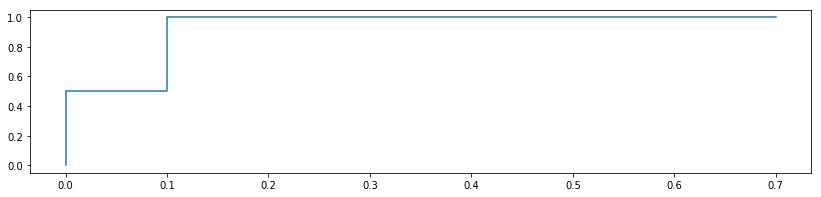

In [26]:
plt.figure(figsize=(14,3))
plt.step(tvec, yout.flatten())

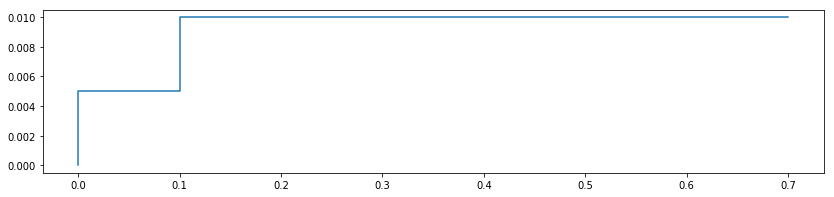

In [27]:
plt.figure(figsize=(14,3))
plt.step(tvec, yout_v.flatten())

# Exercises

## Design a less agressive controller
Consider to let the closed-loop poles be less fast. Choose something reasonable, for instance a double pole in $z=0.5$, or a pair of complex-conjugated poles in $z=0.6 \pm i0.3$. Redo the design, following the example above. Find the state feedback and simulate step-responses.

## Design a deadbeat controller for the DC-motor
From the textbook (Åström & Wittenmark) Appendix:
![title](dcmotor.png)
1. Use symbolic calculations to find the discrete-time state-space model for arbitrary sampling period $h$. 
2. Design a deadbeat controller for arbitrary sampling period.
3. Assume a disturbance is acting on the input to the system, as an unknown torque on the motor shaft. This means that the disturbance enters into the system in the same way as the disturbance on the mass on frictionless surface analyzed above. Simulate step-responses for the closed-loop system.